# Introduction
This notebook contains the code flow for gathering speech signals, performing several short-time analyses, and then grouping the short segments together based on some short-time features. Along the way, several quantitative metrics are extracted, and many plots are presented to aid in visualization.

For this code to run, the following packages will need to be installed
- [librosa](https://librosa.org/doc/latest/index.html) `pip install librosa`
- [numpy](https://numpy.org/doc/stable/) `pip install numpy`
- [sounddevice](https://pypi.org/project/sounddevice/) `pip install sounddevice`
- [scipy](https://scipy.org/) `pip install scipy`
- [matplotlib](https://matplotlib.org/stable/users/installing/index.html#install-an-official-release)
- [dtw](https://dynamictimewarping.github.io/py-api/html/index.html#) `pip install dtw-python`
- [sklearn](https://scikit-learn.org/stable/index.html)
- pandas?

They will then need to be imported with the below cell

In [27]:
#################################################################
# Please run the following cell to import all necessary modules #
#################################################################
import librosa
import numpy as np
import sounddevice as sd
import scipy
from scipy.io import wavfile
from scipy.signal import find_peaks
from scipy.signal import lfilter
from scipy.integrate import simpson
from scipy.stats import chi2
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.io as pio
from dtw import *
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Defining commonly used parameters
audio_path_global = "wavs\LJ001-0083.wav"
samples_global, sample_rate_global = librosa.load(audio_path_global)

<>:2: SyntaxWarning: invalid escape sequence '\L'
<>:2: SyntaxWarning: invalid escape sequence '\L'
C:\Users\tabba\AppData\Local\Temp\ipykernel_30308\3085559373.py:2: SyntaxWarning: invalid escape sequence '\L'
  audio_path_global = "wavs\LJ001-0083.wav"


# Short-time Quantitative Metrics

## Normalizing and Plotting Speech Signal

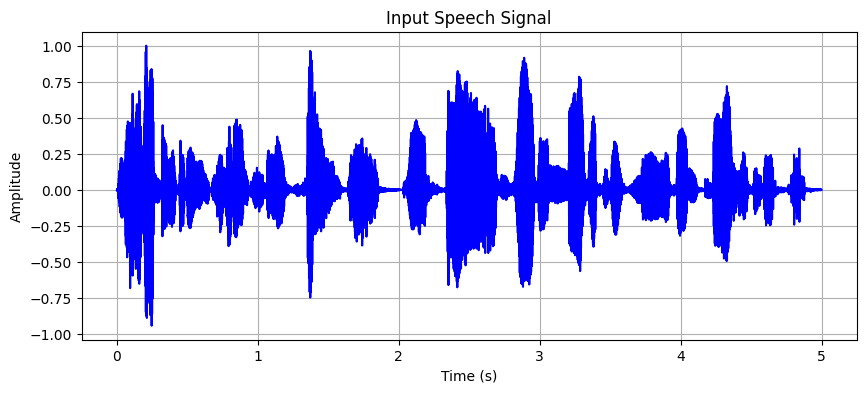

In [13]:
from scipy.io import wavfile

def normalize_and_plot(file_path):

    # take input 
    sample_rate, audio_data = wavfile.read(file_path)
    
    # normalize by using the maximum 
    # rms normalization has the risk of clipping, so we choose max normalization 

    # TODO: do this per window's max? 
    normalized_data = audio_data / np.max(np.abs(audio_data))
    time = np.arange(0, len(audio_data)) / sample_rate

    # plot the normalized speech signal
    plt.figure(figsize=(10, 4))
    plt.plot(time, normalized_data, color='b')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Input Speech Signal')
    plt.grid(True)
    plt.show()

    return normalized_data, sample_rate

normalized_data, sample_rate = normalize_and_plot(audio_path_global)

## Short-time Energy and Zero Crossing Rate (ZCR)

In [14]:
##################################################
# Importing the corresponding Python file        #
# Declaring visualization and auditory functions #
##################################################

from segment_voiced_unvoiced import *

def plot(energy,title,y_label):
    # Create a new figure
    plt.figure(figsize=(10, 4))
    # Plot the energy
    plt.plot(energy)
    # Set the title and labels
    plt.title(title)
    plt.xlabel('Frame')
    plt.ylabel(y_label)
    # Display the plot
    plt.show()

def play(voiced_segments, sample_rate):
    # Concatenate all voiced segments into one array for playback
    voiced_audio = np.concatenate(voiced_segments, axis=0)
    # Play the concatenated voiced audio
    sd.play(voiced_audio, samplerate=sample_rate)
    # Wait for the audio to finish playing
    sd.wait()

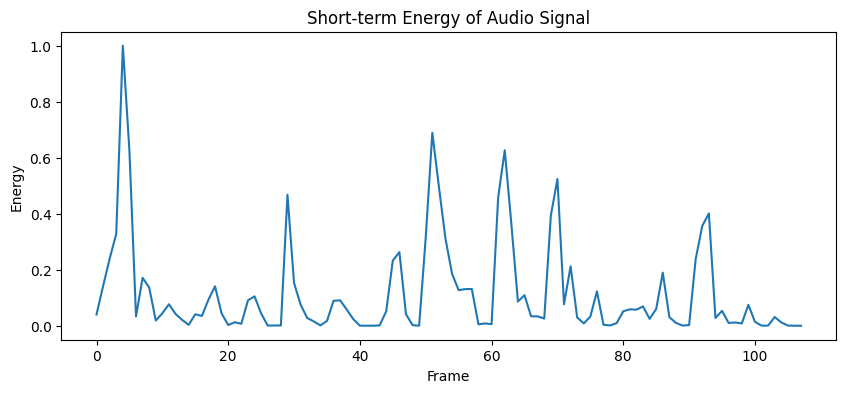

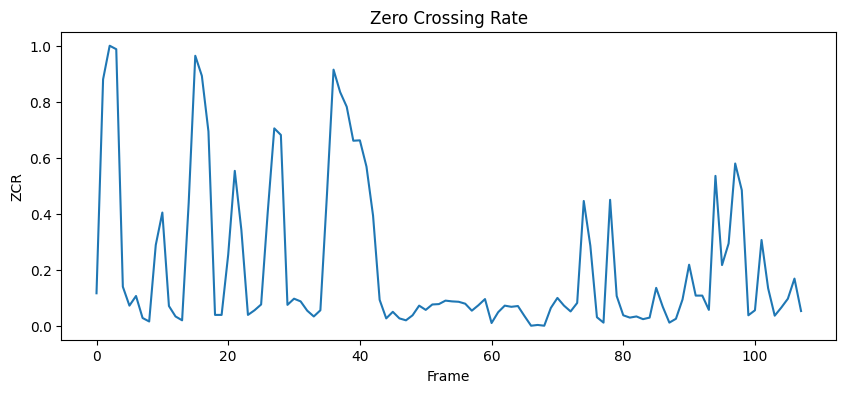

In [15]:
# Load the audio file
# y, sample_rate = librosa.load(audio_path_global)
# Segment audio file
voiced_segments, unvoiced_segments, energy, zcr= segment_audio(samples_global)

# Plot the Energy and Zero Crossing Rate
plot(energy,'Short-term Energy of Audio Signal','Energy')
plot(zcr,'Zero Crossing Rate','ZCR')

# Play separated segments
play(voiced_segments, sample_rate)
play(unvoiced_segments,sample_rate)

# Segmentation Techniques

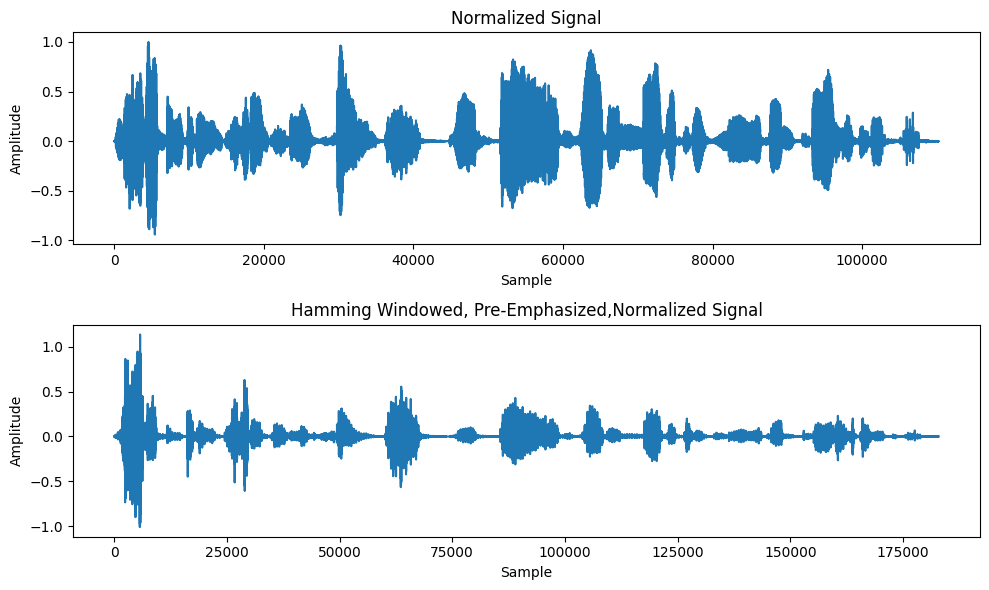

In [19]:
from segmentation import Segmentation

seg_object = Segmentation()
hamming_short_windows, hamming_window_signal = seg_object.split_window_preemphasize(normalized_data, sample_rate, 25, 10, plot=True)

## Peakiness Segmentation

[2204,
 3857,
 5510,
 24795,
 26448,
 29203,
 31407,
 38019,
 43529,
 44631,
 59508,
 61712,
 68875,
 89262,
 100282,
 109098,
 117363,
 119567,
 121220,
 122873,
 126730,
 132791,
 134444,
 136097,
 144913,
 152627,
 160341,
 161443,
 163647,
 164749,
 168055,
 171361,
 172463,
 175218]

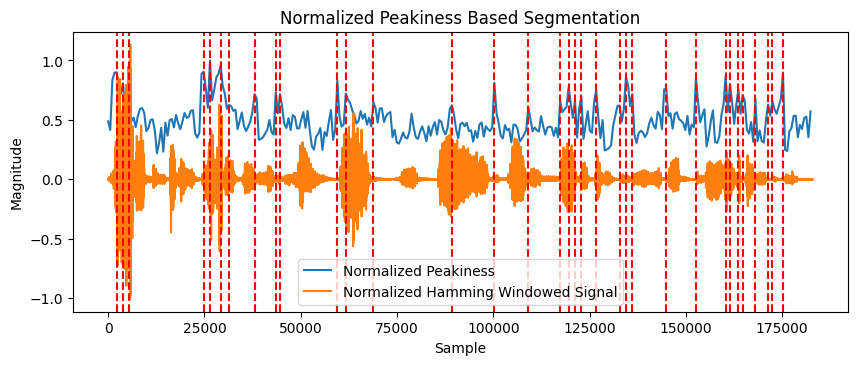

In [21]:
seg_object.peakiness_segmentation(hamming_short_windows)

## Formant Segmentation

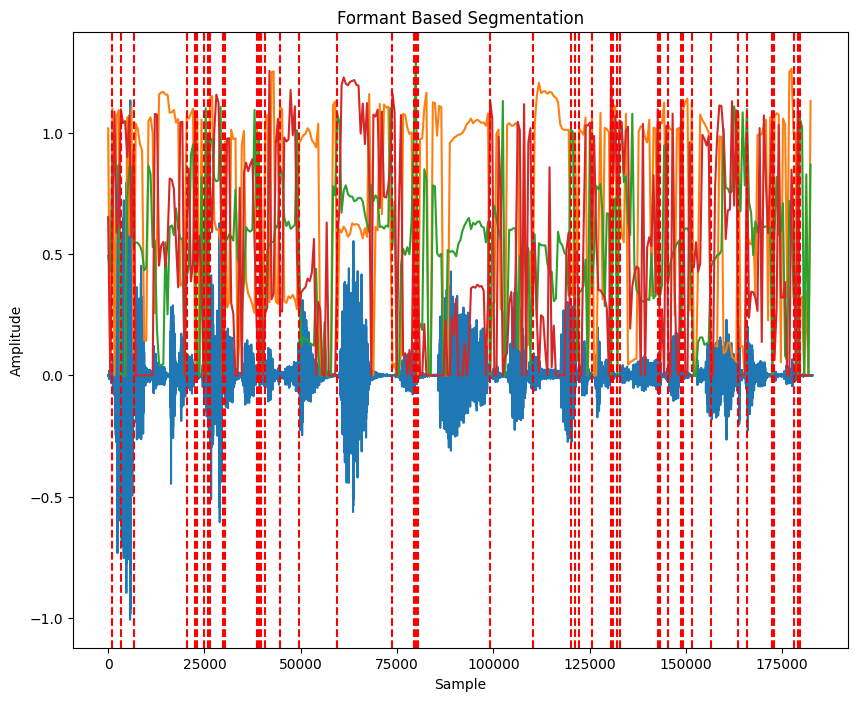

In [22]:
formant_segment_boundaries_samples, formants_at_boundaries = seg_object.formant_segmentation(hamming_short_windows, sample_rate=sample_rate_global)

## Matusita Distance Segmentation

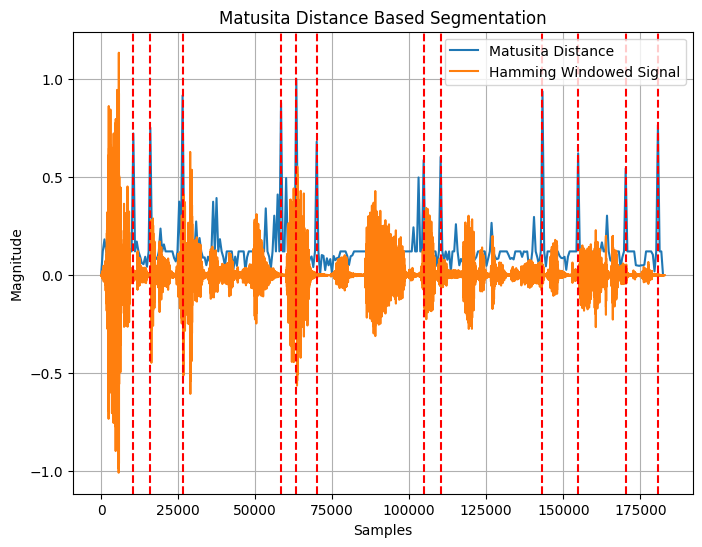

[10469,
 15979,
 26448,
 58406,
 63365,
 69977,
 104690,
 110200,
 143260,
 154831,
 170259,
 180728]

In [23]:
seg_object.matusita_dist_segmentation(hamming_short_windows)

## Teager Energy Segmentation

[1653,
 2204,
 2755,
 3306,
 3857,
 4408,
 4959,
 5510,
 6061,
 6612,
 7163,
 8265,
 8816,
 9367,
 15979,
 16530,
 17081,
 17632,
 18734,
 24795,
 25897,
 26448,
 26999,
 27550,
 28101,
 28652,
 29203,
 29754,
 35264,
 49590,
 60059,
 60610,
 61161,
 61712,
 62263,
 62814,
 63365,
 63916,
 64467,
 65018,
 65569,
 66120,
 66671,
 67222,
 67773,
 85956,
 117363,
 117914,
 120669,
 121220,
 126730,
 127281,
 127832,
 159790,
 160341,
 161443,
 163647,
 164198,
 165851,
 166402,
 166953,
 167504]

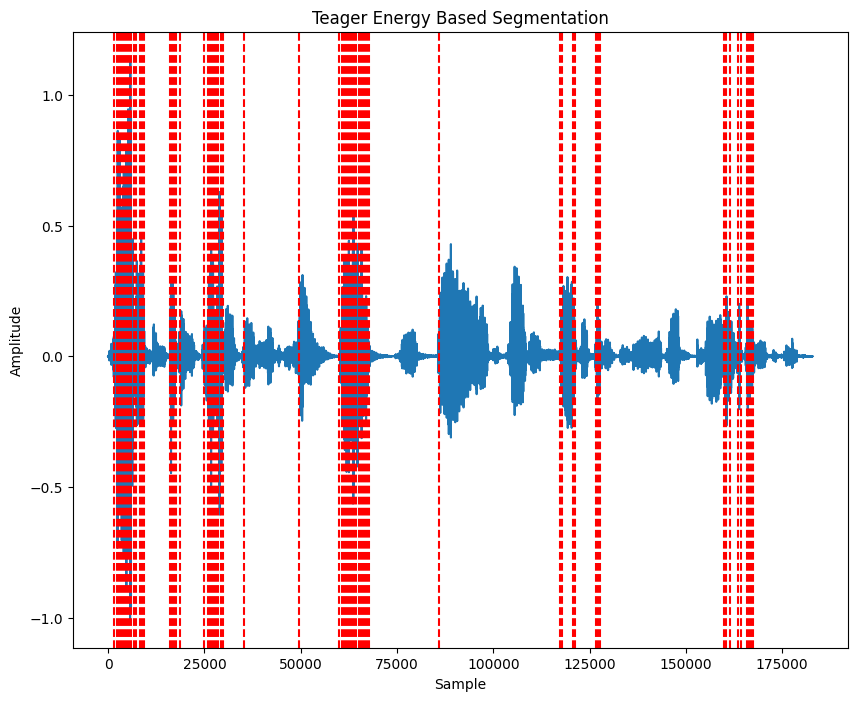

In [24]:
seg_object.teager_energy_segmentation(hamming_short_windows)

## Fitting Process Segmentation

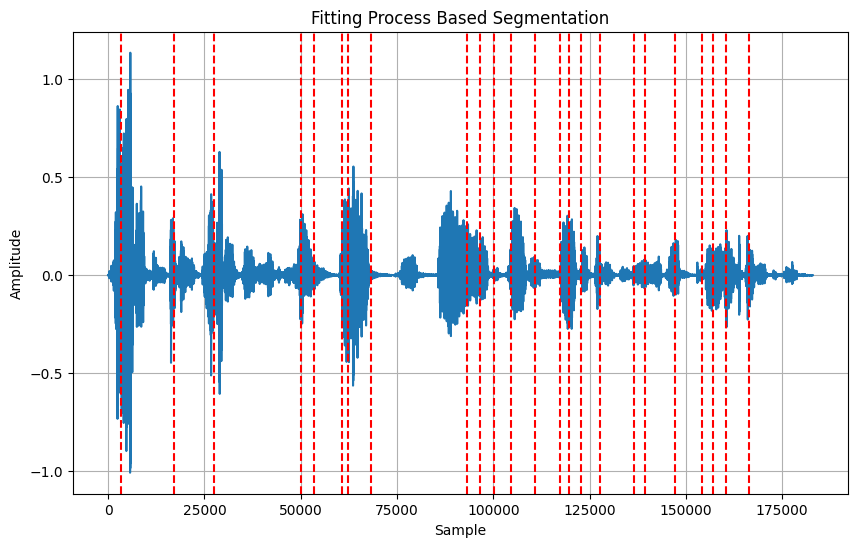

array([  3306,  17081,  27550,  50141,  53447,  60610,  62263,  68324,
        93119,  96425, 100282, 104690, 110751, 117363, 119567, 122873,
       127832, 136648, 139403, 147117, 154280, 157035, 160341, 166402],
      dtype=int64)

In [25]:
seg_object.fitting_proc_segmentation(hamming_short_windows)

# Vector Embeddings

In [39]:
##################################################
# Importing the corresponding Python file        #
##################################################

from vector_embeddings import Vector_Embeddings
vect_embed = Vector_Embeddings()

## Supervised labels for file 'Rhyme_Words.wav'

In [40]:
audio_path = 'Rhyme_Words.wav'
# Load the audio file
y, sample_rate = librosa.load(audio_path)
dtw_matrix_sup = vect_embed.mfcc_dtw_embed(y, sample_rate)

num_words = len(dtw_matrix_sup)

colors = ['blue']*((int)(num_words*0.23)) + ['red']*((int)(num_words*0.19)) + ['purple']*((int)(num_words*0.19)) + ['green']*((int)(num_words*0.15)) + ['orange']*((int)(num_words*0.23))
# Addressing rounding issues
colors = colors + ['orange']*(num_words - len(colors))
print("Shape of dtw_matrix is ", np.shape(dtw_matrix_sup))

Shape of dtw_matrix is  (1026, 651)


## MFCC then DTW

In [41]:
dtw_matrix = vect_embed.mfcc_dtw_embed(samples_global, sample_rate_global)
print("Shape of dtw_matrix is ", np.shape(dtw_matrix))

Shape of dtw_matrix is  (197, 124)


## MFCC

In [42]:
mfcc_matrix = vect_embed.mfcc_embed(samples_global, sample_rate_global)
print("Shape of dtw_matrix is ", np.shape(mfcc_matrix))

Shape of dtw_matrix is  (197, 39)


# Dimensionality Reduction

In [43]:
from sklearn.decomposition import PCA

In [60]:
##################################################
#       Declaring visualization functions        #
##################################################

def visualize_3d(X_3d, fig_title, colors=None):
    df = pd.DataFrame(
            {
                "Feature 1": X_3d[:, 0],
                "Feature 2": X_3d[:, 1],
                "Feature 3": X_3d[:, 2],
            }
        )
    fig = px.scatter_3d(
            df,
            x="Feature 1",
            y="Feature 2",
            z="Feature 3",
            title=fig_title,
            color=colors,
            width=960,
            height=700,
        )
    fig.update_traces(
            marker=dict(size=5), selector=dict(mode="markers")
        )  # Customize if needed
    fig.show()


def visualize_2d(X_2d, fig_title, colors=None):
    df = pd.DataFrame(
            {"Feature 1": X_2d[:, 0], "Feature 2": X_2d[:, 1]}
        )
    fig = px.scatter(
        df, x="Feature 1", y="Feature 2", color=colors, title=fig_title
    )
    fig.show()

## Supervised labels for file 'Rhyme_Words.wav'

In [56]:
dtw_matrix_sup = np.array(dtw_matrix_sup)
dim_red_sup = PCA(n_components=3)
dim_red_sup.fit(dtw_matrix_sup)
print("The explained variance by each PCA component  is ", dim_red_sup.explained_variance_ratio_)
first_components_idxs = np.argsort(np.abs(dim_red_sup.components_[0]))[::-1]
second_components_idxs = np.argsort(np.abs(dim_red_sup.components_[1]))[::-1]
third_components_idxs = np.argsort(np.abs(dim_red_sup.components_[2]))[::-1]

print("The 1st PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red_sup.components_[0][first_components_idxs[0]], " of component ", first_components_idxs[0])
print(dim_red_sup.components_[0][first_components_idxs[1]], " of component ", first_components_idxs[1])
print(dim_red_sup.components_[0][first_components_idxs[2]], " of component ", first_components_idxs[2])

print("The 2nd PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red_sup.components_[1][second_components_idxs[0]], " of component ", second_components_idxs[0])
print(dim_red_sup.components_[1][second_components_idxs[1]], " of component ", second_components_idxs[1])
print(dim_red_sup.components_[1][second_components_idxs[2]], " of component ", second_components_idxs[2])

print("The 3rd PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red_sup.components_[2][third_components_idxs[0]], " of component ", third_components_idxs[0])
print(dim_red_sup.components_[2][third_components_idxs[1]], " of component ", third_components_idxs[1])
print(dim_red_sup.components_[2][third_components_idxs[2]], " of component ", third_components_idxs[2])

threeD_vectors_sup = dim_red_sup.transform(dtw_matrix_sup)
visualize_3d(threeD_vectors_sup, "DTW Word Vectors Only 3 Dimensions", colors)
twoD_vectors_sup = threeD_vectors_sup[:, 0:2]
visualize_2d(twoD_vectors_sup, "DTW Word Vectors Only 2 Dimensions", colors)

# If you experience the error "Mime type rendering requires nbformat>=4.2.0 but it is not installed"
# Type the following in the terminal: "pip install --upgrade nbformat"
# Then, restart the kernal and re-runn the cells

The explained variance by each PCA component  is  [0.87067063 0.07075723 0.02000466]
The 1st PCA component expressed as a linear combination of the original features (columns): 
0.05877825854264754  of component  66
0.05846942375110165  of component  517
0.058436674115860135  of component  201
The 2nd PCA component expressed as a linear combination of the original features (columns): 
0.08189259962645125  of component  263
0.08136719585276603  of component  400
0.08006398581832641  of component  146
The 3rd PCA component expressed as a linear combination of the original features (columns): 
0.13856701811670455  of component  544
0.13192670949234547  of component  394
0.12726182252631138  of component  6


## MFCC then DTW

In [64]:
dtw_matrix = np.array(dtw_matrix)
dim_red = PCA(n_components=3)
dim_red.fit(dtw_matrix)
print("The explained variance by each PCA component  is ", dim_red.explained_variance_ratio_)
first_components_idxs = np.argsort(np.abs(dim_red.components_[0]))[::-1]
second_components_idxs = np.argsort(np.abs(dim_red.components_[1]))[::-1]
third_components_idxs = np.argsort(np.abs(dim_red.components_[2]))[::-1]

print("The 1st PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red.components_[0][first_components_idxs[0]], " of component ", first_components_idxs[0])
print(dim_red.components_[0][first_components_idxs[1]], " of component ", first_components_idxs[1])
print(dim_red.components_[0][first_components_idxs[2]], " of component ", first_components_idxs[2])

print("The 2nd PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red.components_[1][second_components_idxs[0]], " of component ", second_components_idxs[0])
print(dim_red.components_[1][second_components_idxs[1]], " of component ", second_components_idxs[1])
print(dim_red.components_[1][second_components_idxs[2]], " of component ", second_components_idxs[2])

print("The 3rd PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red.components_[2][third_components_idxs[0]], " of component ", third_components_idxs[0])
print(dim_red.components_[2][third_components_idxs[1]], " of component ", third_components_idxs[1])
print(dim_red.components_[2][third_components_idxs[2]], " of component ", third_components_idxs[2])

threeD_vectors_dtw = dim_red.transform(dtw_matrix)
visualize_3d(threeD_vectors_dtw, "DTW Word Vectors Only 3 Dimensions")
twoD_vectors_dtw = threeD_vectors_dtw[:, 0:2]
visualize_2d(twoD_vectors_dtw, "DTW Word Vectors Only 2 Dimensions")

# If you experience the error "Mime type rendering requires nbformat>=4.2.0 but it is not installed"
# Type the following in the terminal: "pip install --upgrade nbformat"
# Then, restart the kernal and re-runn the cells

The explained variance by each PCA component  is  [0.40207443 0.3170412  0.08202118]
The 1st PCA component expressed as a linear combination of the original features (columns): 
0.188222536160459  of component  85
0.18708423596554957  of component  78
0.18436871791046214  of component  17
The 2nd PCA component expressed as a linear combination of the original features (columns): 
0.1497579911233116  of component  76
0.1487391127157032  of component  99
0.1468709396598213  of component  27
The 3rd PCA component expressed as a linear combination of the original features (columns): 
0.22444098306481747  of component  101
0.22324962020097916  of component  21
0.2227936614710248  of component  42


## MFCC

In [65]:
mfcc_matrix_matrix = np.array(mfcc_matrix)
dim_red.fit(mfcc_matrix)
print("The explained variance by each PCA component  is ", dim_red.explained_variance_ratio_)
first_components_idxs = np.argsort(np.abs(dim_red.components_[0]))[::-1]
second_components_idxs = np.argsort(np.abs(dim_red.components_[1]))[::-1]
third_components_idxs = np.argsort(np.abs(dim_red.components_[2]))[::-1]

print("The 1st PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red.components_[0][first_components_idxs[0]], " of MFCC coefficient ", first_components_idxs[0])
print(dim_red.components_[0][first_components_idxs[1]], " of MFCC coefficient ", first_components_idxs[1])
print(dim_red.components_[0][first_components_idxs[2]], " of MFCC coefficient ", first_components_idxs[2])

print("The 2nd PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red.components_[1][second_components_idxs[0]], " of MFCC coefficient ", second_components_idxs[0])
print(dim_red.components_[1][second_components_idxs[1]], " of MFCC coefficient ", second_components_idxs[1])
print(dim_red.components_[1][second_components_idxs[2]], " of MFCC coefficient ", second_components_idxs[2])

print("The 3rd PCA component expressed as a linear combination of the original features (columns): ")
print(dim_red.components_[2][third_components_idxs[0]], " of MFCC coefficient ", third_components_idxs[0])
print(dim_red.components_[2][third_components_idxs[1]], " of MFCC coefficient ", third_components_idxs[1])
print(dim_red.components_[2][third_components_idxs[2]], " of MFCC coefficient ", third_components_idxs[2])

threeD_vectors_mfcc = dim_red.transform(mfcc_matrix)
visualize_3d(threeD_vectors_mfcc, "DTW Word Vectors Only 3 Dimensions")
twoD_vectors_mfcc = threeD_vectors_mfcc[:, 0:2]
visualize_2d(twoD_vectors_mfcc, "DTW Word Vectors Only 2 Dimensions")

# If you experience the error "Mime type rendering requires nbformat>=4.2.0 but it is not installed"
# Type the following in the terminal: "pip install --upgrade nbformat"
# Then, restart the kernal and re-runn the cells

The explained variance by each PCA component  is  [0.47435662 0.26554224 0.05760186]
The 1st PCA component expressed as a linear combination of the original features (columns): 
-0.82645977  of MFCC coefficient  0
-0.38243973  of MFCC coefficient  1
0.3498008  of MFCC coefficient  2
The 2nd PCA component expressed as a linear combination of the original features (columns): 
-0.84193736  of MFCC coefficient  1
0.4711605  of MFCC coefficient  0
0.17614406  of MFCC coefficient  2
The 3rd PCA component expressed as a linear combination of the original features (columns): 
-0.74781716  of MFCC coefficient  3
0.46368343  of MFCC coefficient  5
-0.29635823  of MFCC coefficient  4


# Applying a DBScan Model

## Supervised labels for file 'Rhyme_Words.wav'

In [66]:
db_model_threeD_sup = DBSCAN(eps=10.0, min_samples=3).fit(threeD_vectors_sup)
db_colors_threeD_sup = db_model_threeD_sup.labels_
visualize_3d(threeD_vectors_sup, "DBScan on 3D DTW Vectors", db_colors_threeD_sup)

db_model_twoD_sup = DBSCAN(eps=10.0, min_samples=3).fit(twoD_vectors_sup)
db_colors_twoD_sup = db_model_twoD_sup.labels_
visualize_2d(twoD_vectors_sup, "DBScan on 2D DTW Vectors", db_colors_twoD_sup)

## MFCC then DTW

In [67]:
db_model_threeD_dtw = DBSCAN(eps=10.0, min_samples=3).fit(threeD_vectors_dtw)
db_colors_threeD_dtw = db_model_threeD_dtw.labels_
visualize_3d(threeD_vectors_dtw, "DBScan on 3D DTW Vectors", db_colors_threeD_dtw)

db_model_twoD_dtw = DBSCAN(eps=10.0, min_samples=3).fit(twoD_vectors_dtw)
db_colors_twoD_dtw = db_model_twoD_dtw.labels_
visualize_2d(twoD_vectors_dtw, "DBScan on 2D DTW Vectors", db_colors_twoD_dtw)

## MFCC

In [68]:
db_model_threeD_mfcc = DBSCAN(eps=10.0, min_samples=3).fit(threeD_vectors_mfcc)
db_colors_threeD_mfcc = db_model_threeD_mfcc.labels_
visualize_3d(threeD_vectors_mfcc, "DBScan on 3D DTW Vectors", db_colors_threeD_mfcc)

db_model_twoD_mfcc = DBSCAN(eps=10.0, min_samples=3).fit(twoD_vectors_mfcc)
db_colors_twoD_mfcc = db_model_twoD_mfcc.labels_
visualize_2d(twoD_vectors_mfcc, "DBScan on 2D DTW Vectors", db_colors_twoD_mfcc)